# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two models for DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [1]:
import pandas as pd
import glob
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pickle
import tensorflow as tf


/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
 
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [3]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [4]:
reduced_df = result[['act_tag','text']]


In [5]:
reduced_df.head()


,act_tag,text
0,fp,"Hi, /"
1,fp,how are you today? /
2,fp,I'm great <laughter>. /
3,fp,Good. /
4,sd,"{D Well } as a matter of fact [ I'm, + befor..."


Theere are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

In [6]:
act_tag_counts = reduced_df['act_tag'].value_counts()
# Reduce the number of classes by replacing rare labels with the 'other' token
# By reducing the number i help to reduce the class imbalance 
# and also scale the confusion matrix down to a size that allows for interpretation
threshold = 20
for label in act_tag_counts.keys():
    if act_tag_counts[label] < threshold:
        reduced_df.replace(label,'other', inplace=True)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


## Baseline BiLSTM Model

To get unique tags. 

In [7]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [8]:
# Load the onehot encoding dataframe from disk to avoid re-runs incorrectly mapping vectors
import os.path
fname = "one_hot_encoding_dic.pickle"
if os.path.isfile(fname):
    pickle_in = open(fname,"rb")
    one_hot_encoding_dic = pickle.load(pickle_in)
else:
    one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


pickle_out = open(fname,"wb")
pickle.dump(one_hot_encoding_dic, pickle_out)
pickle_out.close()

In [9]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [10]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [11]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [12]:
MAX_LENGTH = len(max(sentences, key=len))


In [13]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [15]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.

In [20]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam
#Building the network
numberOfTags = len(reduced_df['act_tag'].value_counts())
embed_dim = 50

model = Sequential()
model.add(Embedding(len(wordvectors)+1, output_dim=embed_dim, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(numberOfTags,activation='softmax' ))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
weightsFilePath ="weights.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 137, 50)           2186600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_2 (Dense)              (None, 94)                12126     
Total params: 2,257,606
Trainable params: 2,257,606
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Save the best weights to a file so we get the model with the best val acc
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_sentences_X,y_train,epochs=5,batch_size=512,validation_data=(test_sentences_X, y_test), callbacks=[checkpoint],verbose=1)

Train on 167704 samples, validate on 55902 samples
Epoch 1/5
 13824/167704 [=>............................] - ETA: 2:44 - loss: 2.3588 - acc: 0.3982

KeyboardInterrupt: 

In [21]:
model.load_weights(weightsFilePath)
#score = model.evaluate(test_sentences_X, y_test, batch_size=100)

In [22]:
bfTotal = 0.0
brTotal = 0.0
sdTotal = 0.0
for i,row in enumerate(y_test):
    if np.array_equal(row,one_hot_encoding_dic['br']):
        brTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['bf']):
        bfTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['sd']):
        sdTotal += 1.0
        
print(bfTotal)
print(brTotal)
print(sdTotal)

242.0
68.0
17531.0


In [23]:
for i,key in enumerate(one_hot_encoding_dic.keys()):
    if key == 'br':
        brConfusionMatrixIndex = i
    elif key == 'bf':
        bfConfusionMatrixIndex = i
    elif key == 'sd':
        sdConfusionMatrixIndex = i
print(brConfusionMatrixIndex)
print(bfConfusionMatrixIndex)
print(sdConfusionMatrixIndex)

33
28
72


In [24]:
y_pred = model.predict(test_sentences_X)

In [25]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])

/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


In [26]:
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
print(f"The br was most commonly confused with: {one_hot_encoding_dic.keys()[brCommonMistakes.argmax()]}")

bfCommonMistakes = cm[bfConfusionMatrixIndex]
print(f"The bf was most commonly confused with: {one_hot_encoding_dic.keys()[bfCommonMistakes.argmax()]}")

br Accuracy: 0.4117647058823529, bf accuracy: 0.012396694214876033,sd Accuracy: 0.8742798471279448 
Overall accuracy: 72.62709742048585
The br was most commonly confused with: br
The bf was most commonly confused with: sv


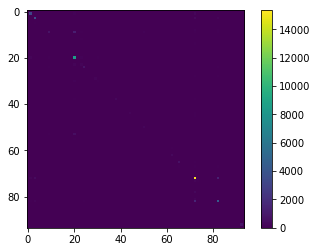

<Figure size 432x288 with 0 Axes>

In [27]:
# The br and bf sentences are incorrectly labelled as aa and sd. 
# I think this is because aa and sd are the most common classes in the dataset
# The 0% accuracy for bf and br was concering so i decided to plot thw whole confusion matrix to see what was happening
# The confusion matrix is mostly dark with a small number of bright dots. These are the classes it tries to classify
# This indicates that the large class imbalance has caused the model to only output a small number of classes rather than the full range
# It simply accepts it will get the other classes wrong as it is still able to achieve good (>60%) accuracy without using them
plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("confusionmatrix.png")

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [16]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
classBalancedWeightsFilePath = "classBalanced" + weightsFilePath

NameError: name 'weightsFilePath' is not defined

In [ ]:

classBalancedCheckpoint = ModelCheckpoint(classBalancedWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(train_sentences_X, y_train, batch_size=512, epochs=5, class_weight = d_class_weights, validation_data=(test_sentences_X, y_test), callbacks=[classBalancedCheckpoint])

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

##Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each sentence for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current sentence. The left-to-right LSTM output and the one from the reverse direction are concatenated and input to a hidden layer for classification.

Functions for creating weights and biases.

In [17]:
def weights_init(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

In [18]:
def bias_init(shape):
    return tf.Variable(tf.zeros(shape=shape))


 This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN.
    
      Input(s): 
              input - word_embedings
              filter_size - size of width and height of the Conv kernel
              number_of_channels - in this case it is always 1
              number_of_filters - how many representation of the input utterance are we going to output from this layer 
              strides - how many does kernel move to the side and up/down
              activation - a activation function
              max_pool - boolean value which will trigger a max_pool operation on the output tensor
      Output(s): 
               text_conv layer
    

In [19]:
def text_conv(input, filter_size, number_of_channels, number_of_filters, strides=(1, 1), activation=tf.nn.relu, max_pool=True):
    
    weights = weights_init([filter_size, filter_size, number_of_channels, number_of_filters])
    bias = bias_init([number_of_filters])
    
    layer = tf.nn.conv2d(input, filter=weights, strides=[1, strides[0], strides[1], 1], padding='SAME')
    
    if activation != None:
        layer = activation(layer)
    
    if max_pool:
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2 ,1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer

    This method is used to create LSTM layer. And the data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You can create a BiLSTM by modifying this.
    
    Input(s): lstm_cell_unitis - used to define the number of units in a LSTM layer
              number_of_layers - used to define how many of LSTM layers do we want in the network
              batch_size - in this method this information is used to build starting state for the network
              dropout_rate - used to define how many cells in a layer do we want to 'turn off'
              
    Output(s): cell - lstm layer
               init_state - zero vectors used as a starting state for the network

In [20]:
def lstm_layer(lstm_size, number_of_layers, batch_size, dropout_rate):

    def cell(size, dropout_rate=None):
        layer = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        return tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
    cell = tf.contrib.rnn.MultiRNNCell([cell(lstm_size, dropout_rate) for _ in range(number_of_layers)])
    
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, init_state

    Use to transform/reshape conv output to 2d matrix, if it's necessary
    
    Input(s): Layer - text_cnn layer
              batch_size - how many samples do we feed at once
              seq_len - number of time steps
              
    Output(s): reshaped_layer - the layer with new shape
               number_of_elements - this param is used as a in_size for next layer

In [21]:
def flatten(layer, batch_size, seq_len):

    dims = layer.get_shape()
    number_of_elements = dims[2:].num_elements()
    
    reshaped_layer = tf.reshape(layer, [batch_size, int(seq_len/2), number_of_elements])
    return reshaped_layer, number_of_elements

    Output layer for the lstm netowrk
    
    Input(s): lstm_outputs - outputs from the RNN part of the network
              input_size - in this case it is RNN size (number of neuros in RNN layer)
              output_size - number of neuros for the output layer == number of classes
              
    Output(s) - logits, 

In [22]:
def dense_layer(input, in_size, out_size, dropout=False, activation=tf.nn.relu):
  
    weights = weights_init([in_size, out_size])
    bias = bias_init([out_size])
    
    layer = tf.matmul(input, weights) + bias
    
    if activation != None:
        layer = activation(layer)
    
    if dropout:
        layer = tf.nn.dropout(layer, 0.5)
        
    return layer

    Function used to calculate loss and minimize it
    
    Input(s): rnn_out - logits from the fully_connected layer
              targets - targets used to train network
              learning_rate/step_size
    
    
    Output(s): optimizer - optimizer of choice
               loss - calculated loss function

In [23]:
def loss_optimizer(logits, targets, learning_rate, ):

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss, optimizer

To create the model you can use these inputs:     
       
       Input(s): learning_rate/step_size - how fast are we going to find global minima
                  batch_size -  the nuber of samples to feed at once
                  seq_len - the number of timesteps in unrolled RNN
                  vocab_size - the number of nunique words in the vocab
                  embed_size - length of word embed vectors
                  conv_filters - number of filters in output tensor from CNN layer
                  conv_filter_size - height and width of conv kernel
                  number_of_lstm_layers - the number of layers used in the LSTM part of the network
                  lstm_units - the number of neurons/cells in a LSTM layer

In [74]:
class DATagging(object):
    
    def __init__(self, learning_rate=0.001, batch_size=100, seq_len=250, vocab_size=10000, embed_size=300,
                conv_filters=32, conv_filter_size=5, number_of_lstm_layers=1, lstm_units=128):
        
        # Clear tf graph for multiple cell running
        tf.reset_default_graph()
        
        # Create placeholders
        inputSentences = tf.placeholder(tf.int32, [batch_size, seq_len], name='inputSentences')
        targetSentences = tf.placeholder(tf.float32, [batch_size, seq_len], name='targetSentences')    
        
        #Embedding layer
        # Initialise word embeddings with random uniform dist
        wordEmbeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size]))
        # Embedding layer
        embeddingLayer = tf.nn.embedding_lookup(wordEmbeddings, inputSentences)
        
        # Reshape embedding layer
        embeddingLayer = tf.expand_dims(embeddingLayer, -1)
        
        # Conv layer
        number_of_channels = 1
        sentence_embedding = text_conv(embeddingLayer, conv_filter_size,number_of_channels, conv_filters)
        flat_sentence_embedding, size = flatten(sentence_embedding, batch_size, seq_len)
        
        # BiLSTM layers
        lstm_cell, init_state = lstm_layer(lstm_units, number_of_lstm_layers, batch_size, dropout_rate = 0.3)
        (outputs,states) = tf.nn.bidirectional_dynamic_rnn(lstm_cell,
                                                       lstm_cell, 
                                                       flat_sentence_embedding,
                                                       dtype=tf.float32)
        # Need to reshape the outputs to be [128,250]
        (forwardOutputs,backwardOutputs) = outputs
        print(forwardOutputs)
        shapedOutputs = tf.concat([forwardOutputs[-1,:,:],backwardOutputs[-1,:,:]], 0)
        #shapedOutputs = tf.concat(outputs,2)
        print(shapedOutputs)
        # Hidden layer, with relu activation as we want it to output word embeddings
        denseLayer = dense_layer(shapedOutputs, lstm_units, seq_len)
        print(denseLayer)
        self.loss, self.optimizer = loss_optimizer(denseLayer, targetSentences, learning_rate)
        
        correct = tf.equal(tf.cast(tf.round(denseLayer), tf.int32), tf.cast(self.targets, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(currect_pred, tf.float32))


In [75]:
model = DATagging(learning_rate=0.001, 
                     batch_size=50, 
                     seq_len=250, 
                     vocab_size=len(wordvectors) + 1, 
                     embed_size=300,
                     conv_filters=32, 
                     conv_filter_size=5, 
                     number_of_lstm_layers=1, 
                     lstm_units=128)


Tensor("bidirectional_rnn/fw/fw/transpose_1:0", shape=(50, 125, 128), dtype=float32)
Tensor("concat:0", shape=(250, 128), dtype=float32)
Tensor("Relu_1:0", shape=(250, 250), dtype=float32)


ValueError: logits and labels must have the same shape ((250, 250) vs (50, 250))

Compared to the baseline using BiLSTM for utterance classification, the second method effectively leverage context information and achieve better performance. Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




## Advanced: Creating End-To-End Dialogue System

In the last section we want to create end-to-end dialogue system, following on from the seq2seq MT labs you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. In end-to-end dialogue systems, the encoder represents each utterance with a vector. The utterance vector is the hidden state after the last token of the utterance has been processed. The context LSTM keeps track of past utterances. The hidden state can be explained as the state of the dialogue system. The next utterance prediction is performed by a decoder LSTM, which takes the hidden state of the last LSTM and produces a probability distribution over the tokens in the next utterance. You can take the DA LSTM state of last section as input to a decoder which tries to generate the next utterance. You can add attention and monitor the performance. Instead of evaluating by an automatic evaluation method, you can show us some of the interesting predictions. 
